In [1]:
import os
import imageio
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import json
from skimage.metrics import structural_similarity as ssim
import scipy.signal as signal
import pickle
import scipy

import sys
sys.path.append('models/')
sys.path.append('data/')
from resunet_pf import ResUNet
from IO import *

%load_ext autoreload
%autoreload 2

In [2]:
import lpips
alex_loss_fn = lpips.LPIPS(net = 'alex').cuda()
vgg_loss_fn = lpips.LPIPS(net = 'vgg').cuda()
def percep_loss(img, gt, loss_fn):
    img = torch.from_numpy(img.transpose(2,0,1).astype(np.float32)).unsqueeze(0).cuda()
    gt = torch.from_numpy(gt.transpose(2,0,1).astype(np.float32)).unsqueeze(0).cuda()
    return loss_fn(img, gt).item()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/szh/miniconda/lib/python3.6/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/szh/miniconda/lib/python3.6/site-packages/lpips/weights/v0.1/vgg.pth


## Evaluate on Synthetic Data

In [3]:
from data_utils import stn, mod_flash, get_dshift_pattern, get_pattern_raw, get_ft3d_fd_eval, get_simu_eval

In [4]:
data_dir = '/media/data1/szh/FT3D/frames_cleanpass/TRAIN/A/'
disp_dir = data_dir.replace('frames_cleanpass', 'disparity')
with open('data/dataset_splits/val_small_split.txt', 'r') as f:
    file_list = f.read().splitlines()

Uniform Flash, power: 0.005, PSNR: 26.17, SSIM: 0.85, LPIPS: 0.41
Patterned Flash, power: 0.005, PSNR: 27.83, SSIM: 0.89, LPIPS: 0.34


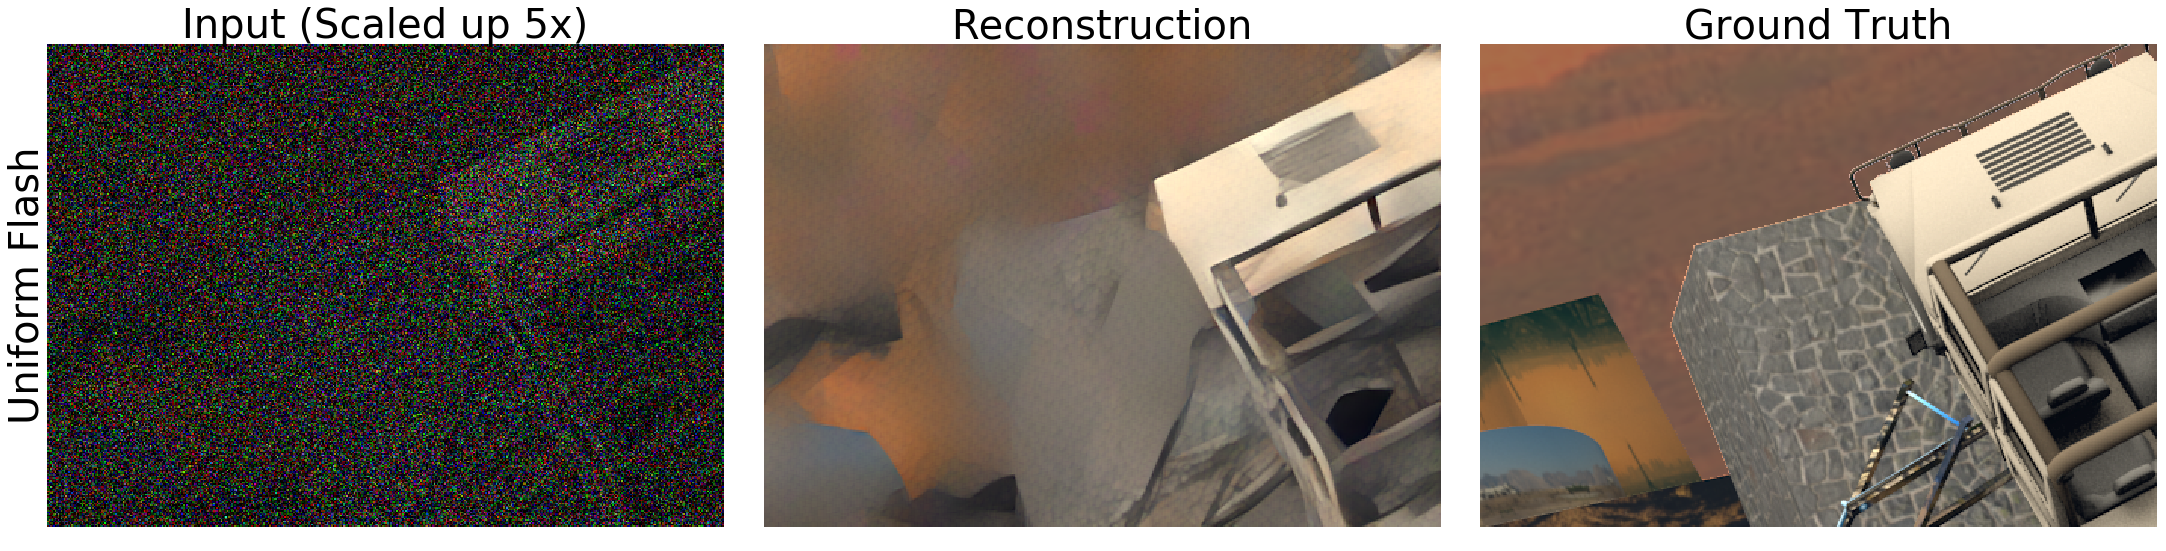

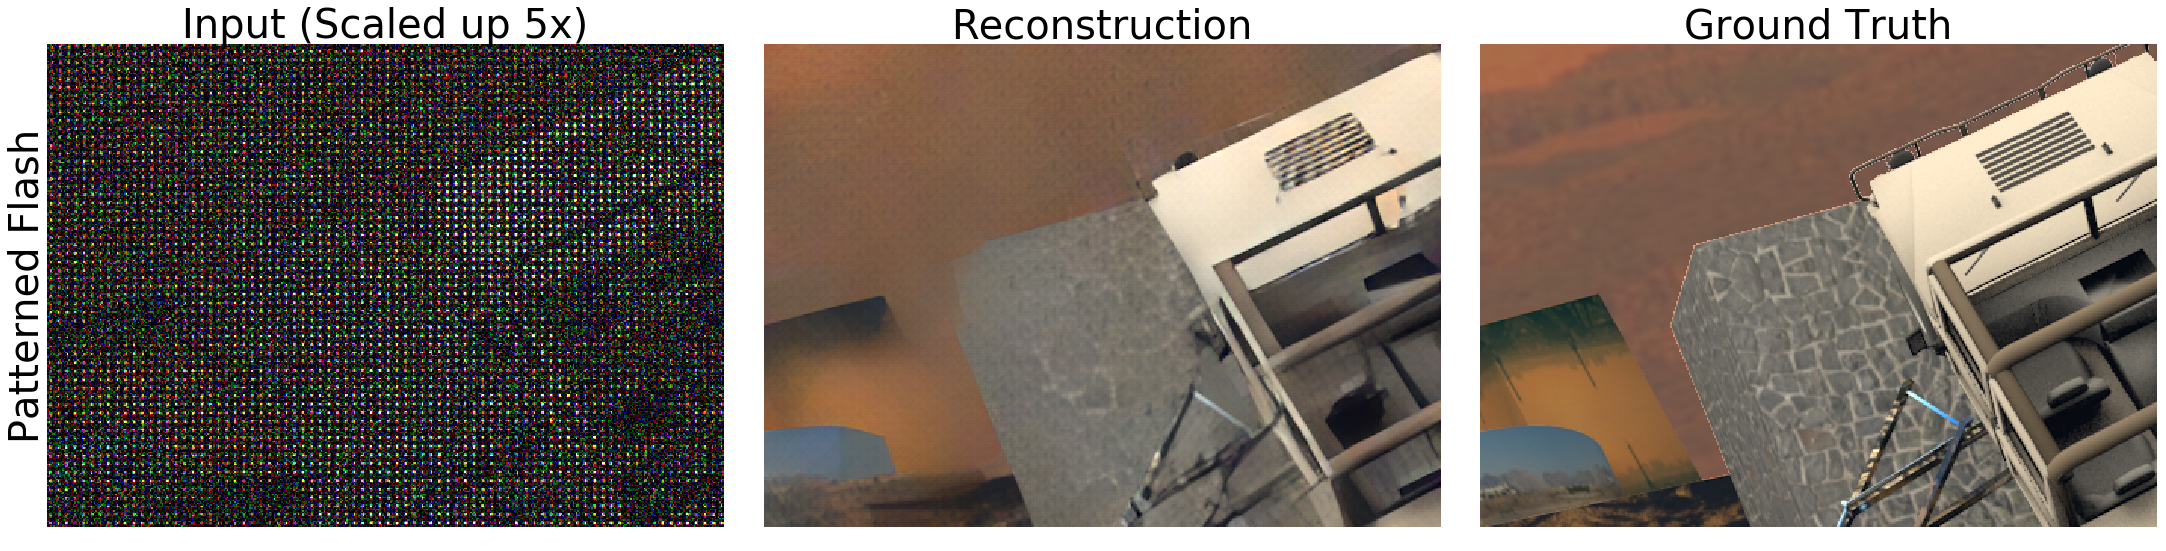

In [8]:
"""
simulation parameters
"""
simu_kwargs = {'poiss_K': 1.5, 'noise': 0.004,  ## noise
               'crop_H': 320, 'crop_W': 448,  ## image cropping
               'baseline': 2.0,  ## baseline
               'fname': file_list[8],  ## file id
               'depth_clip': 1.5,  ## depth clip
               'power': 0.005, ## flash power
               'boost': 16 ## pattern boost
              } 

pattern_names = {'pf': 'Patterned Flash', 'uf': 'Uniform Flash'}
for pattern_type in ['uf', 'pf']:
    """
    load pretrained model
    """
    model_dir = 'checkpoints/{}_pretrained.pth'.format(pattern_type)
    model = ResUNet(in_chans = 8, out_chans = 5, disp_clip = 3.0)
    model.cuda()
    model_state_dict = torch.load(model_dir)
    model.load_state_dict(model_state_dict)
    model.eval()
    
    """
    load synthetic data
    """
    flash, depth = get_ft3d_fd_eval(data_dir, disp_dir, **simu_kwargs)
    pattern_calib = np.load('captured_data/{}_pattern_calib.npy'.format(pattern_type)).astype(np.float32)
    img_flash = get_simu_eval(pattern_calib, flash, depth, **simu_kwargs)

    """
    reconstruction
    """
    with torch.no_grad():
        restore = model(torch.from_numpy(img_flash.transpose(2,0,1)).unsqueeze(0).cuda()).cpu().numpy()[0].transpose(1,2,0)
    restore[...,0] *= np.mean(flash[...,0])/np.mean(restore[...,0])
    restore[...,1] *= np.mean(flash[...,1])/np.mean(restore[...,1])
    restore[...,2] *= np.mean(flash[...,2])/np.mean(restore[...,2])

    """
    compute metrices
    """
    ssim_stat = ssim(restore[...,:3], flash[...,:3], multichannel=True)
    psnr_stat = 20*np.log10(1/np.sqrt(np.mean((flash[...,:3] - restore[...,:3])**2)))
    lpips_stat = percep_loss(restore[...,:3], flash[...,:3], vgg_loss_fn)

    print('{}, power: {}, PSNR: {}, SSIM: {}, LPIPS: {}'.format(pattern_names[pattern_type], \
            simu_kwargs['power'], np.round(psnr_stat,2), np.round(ssim_stat,2), np.round(lpips_stat, 2)))

    """
    plot input and result, scale images for better visualization
    """
    fig, ax = plt.subplots(1,3,figsize = (30,10))
    ax[0].imshow(np.clip(img_flash[...,:3]*5, 0.0, 1.0))
    ax[0].text(0.0, 0.5, pattern_names[pattern_type],
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=ax[0].transAxes, fontsize = 40.0)
    ax[0].set_title('Input (Scaled up 5x)', fontsize = 40.0)
    ax[1].imshow(np.clip(restore[...,:3] * 1.5, 0.0, 1.0))
    ax[1].set_title('Reconstruction', fontsize = 40.0)
    ax[2].imshow(np.clip(flash[...,:3] * 1.5, 0.0, 1.0))
    ax[2].set_title('Ground Truth', fontsize = 40.0)

    for ii in range(3):
        ax[ii].axis('off')
    plt.tight_layout()


## Evaluate on Real-world Data (zero baseline)

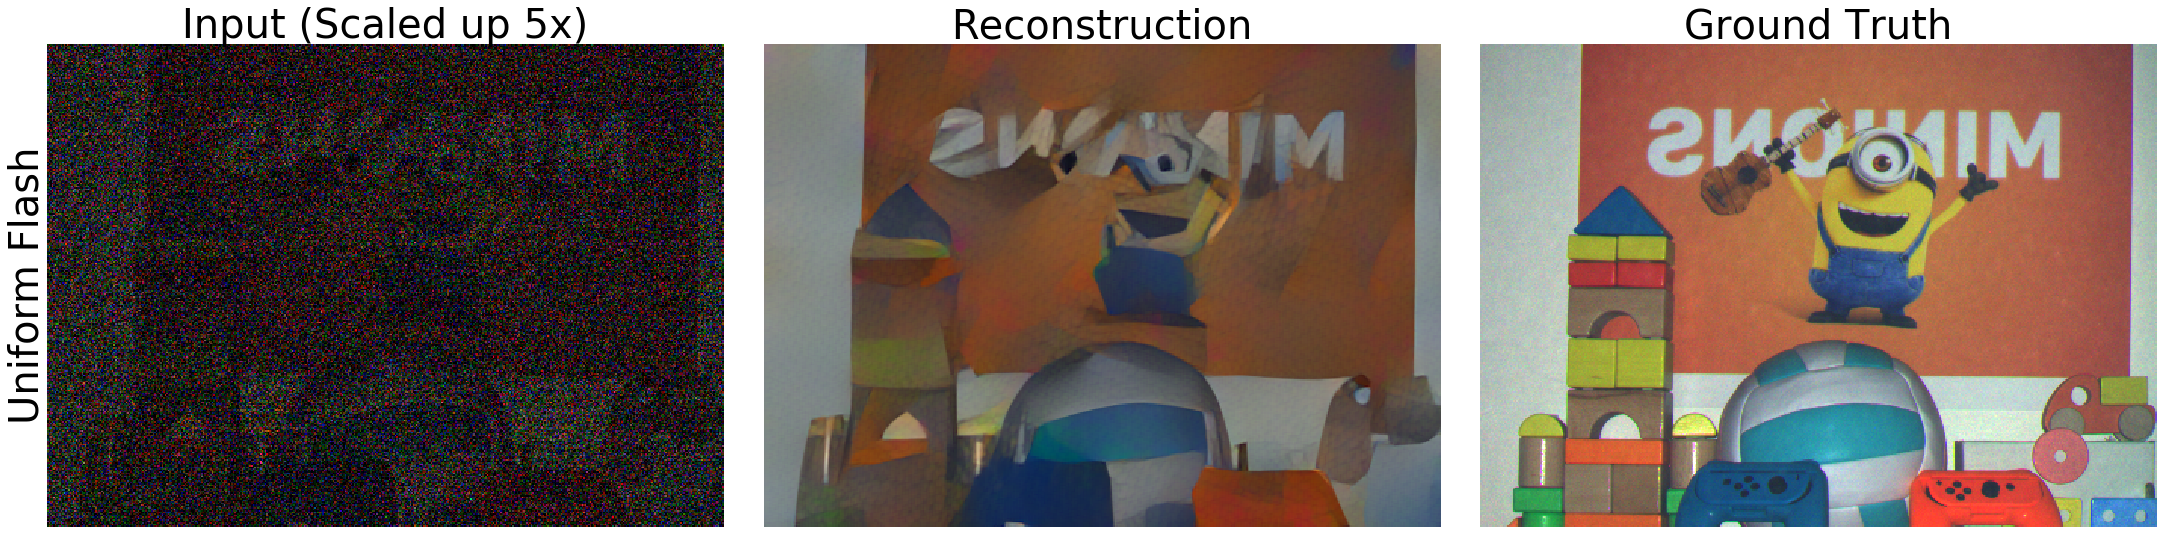

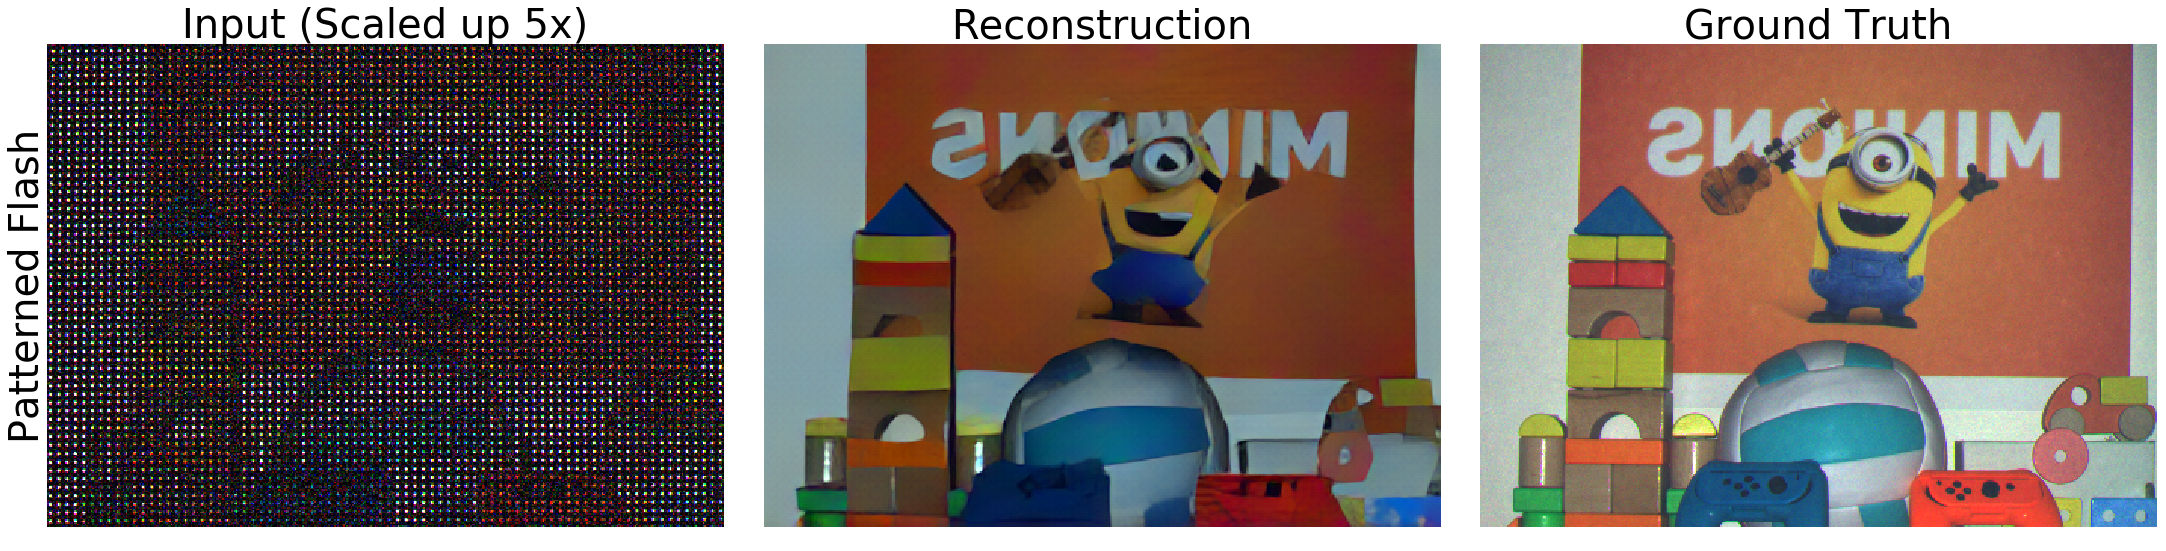

In [6]:
color_matrix = np.asarray([[1.59,-0.43,-0.16],[-0.25,1.71,-0.47],[-0.06,-0.41,1.46]])
## calibrated camera color matrix

pattern_names = {'pf': 'Patterned Flash', 'uf': 'Uniform Flash'}
for pattern_type in ['uf', 'pf']:
    """
    load model
    """
    model_dir = '{}_pretrained.pth'.format(pattern_type)
    model = ResUNet(in_chans = 8, out_chans = 5, disp_clip = 3.0)
    model.cuda()
    model_state_dict = torch.load(model_dir)
    model.load_state_dict(model_state_dict)
    model.eval()

    """
    load data: RGGB raw + calibrated pattern
    """
    # power = 0.0022
    inp_load = np.load('captured_data/{}_scene2.npy'.format(pattern_type))
    # inp_load[...,:4] /= power * 16
    gt = np.load('captured_data/gt_scene2.npy')

    """
    reconstruction
    """
    with torch.no_grad():
        restore = model(torch.from_numpy(inp_load.transpose(2,0,1)).unsqueeze(0).cuda()).cpu().numpy()[0].transpose(1,2,0)
    restore[...,0] *= np.mean(gt[...,0])/np.mean(restore[...,0])
    restore[...,1] *= np.mean(gt[...,1])/np.mean(restore[...,1])
    restore[...,2] *= np.mean(gt[...,2])/np.mean(restore[...,2])
    
    """
    plot input and result, white balance and scale images for better visualization
    """
    gt_wb = (color_matrix @ (gt[...,:3]*1.5).transpose(2,0,1).reshape(3,-1)).reshape(3,320,448).transpose(1,2,0)
    restore_wb = (color_matrix @ restore[...,:3].transpose(2,0,1).reshape(3,-1)).reshape(3,320,448).transpose(1,2,0)

    fig, ax = plt.subplots(1,3,figsize = (30,10))
    ax[0].imshow(np.clip(inp_load[...,:3]*5, 0.0, 1.0))
    ax[0].text(0.0, 0.5, pattern_names[pattern_type],
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=ax[0].transAxes, fontsize = 40.0)
    ax[0].set_title('Input (Scaled up 5x)', fontsize = 40.0)
    ax[1].imshow(np.clip(restore_wb, 0.0, 1.0))
    ax[1].set_title('Reconstruction', fontsize = 40.0)
    ax[2].imshow(np.clip(gt_wb, 0.0, 1.0))
    ax[2].set_title('Ground Truth', fontsize = 40.0)

    for ii in range(3):
        ax[ii].axis('off')
    plt.tight_layout()

## Evaluate on Real-world Data (non-zero baseline)
The scene is slightly misaligned with the zero-baseline case due to limitation in experiment

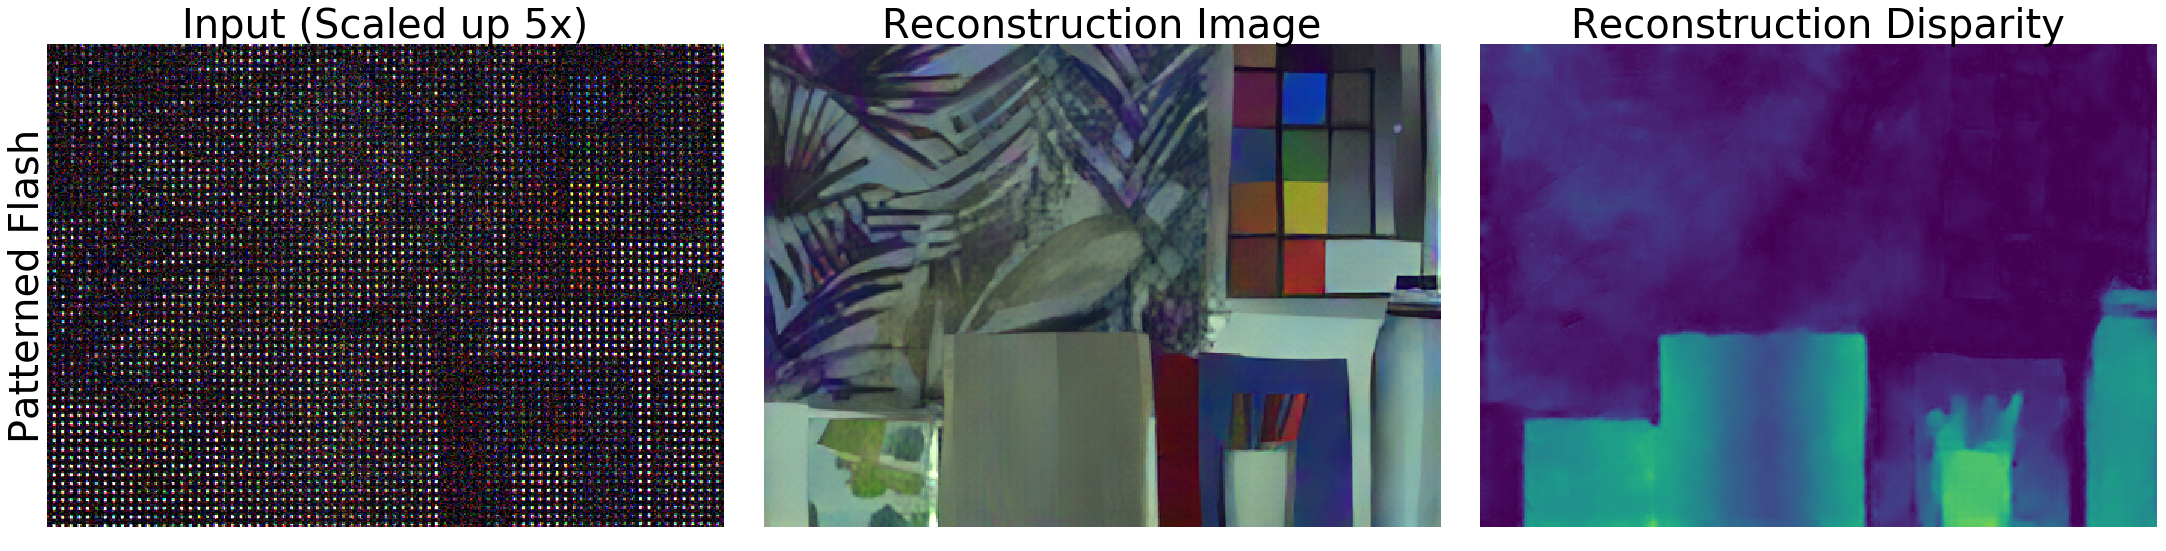

In [7]:
"""
load model
"""
model_dir = 'pf_pretrained.pth'
model = ResUNet(in_chans = 8, out_chans = 5, disp_clip = 3.0)
model.cuda()
model_state_dict = torch.load(model_dir)
model.load_state_dict(model_state_dict)
model.eval()

"""
load data: RGGB raw + calibrated pattern
"""
# power = 0.0022
inp_load = np.load('captured_data/pf_scene1_shift.npy')
# inp_load[...,:4] /= power * 16
gt = np.load('captured_data/gt_scene1.npy')

"""
reconstruction
"""
with torch.no_grad():
    restore = model(torch.from_numpy(inp_load.transpose(2,0,1)).unsqueeze(0).cuda()).cpu().numpy()[0].transpose(1,2,0)
restore[...,0] *= np.mean(gt[...,0])/np.mean(restore[...,0])
restore[...,1] *= np.mean(gt[...,1])/np.mean(restore[...,1])
restore[...,2] *= np.mean(gt[...,2])/np.mean(restore[...,2])

"""
plot input and result, white balance and scale images for better visualization
"""
restore_wb = (color_matrix @ restore[...,:3].transpose(2,0,1).reshape(3,-1)).reshape(3,320,448).transpose(1,2,0)

fig, ax = plt.subplots(1,3,figsize = (30,10))
ax[0].imshow(np.clip(inp_load[...,:3]*5, 0.0, 1.0))
ax[0].text(0.0, 0.5, 'Patterned Flash',
    horizontalalignment='right',
    verticalalignment='center',
    rotation='vertical',
    transform=ax[0].transAxes, fontsize = 40.0)
ax[0].set_title('Input (Scaled up 5x)', fontsize = 40.0)
ax[1].imshow(np.clip(restore_wb, 0.0, 1.0))
ax[1].set_title('Reconstruction Image', fontsize = 40.0)
ax[2].imshow(np.abs(restore[...,-2]), vmin = 0.0, vmax = 3.0)
ax[2].set_title('Reconstruction Disparity', fontsize = 40.0)

for ii in range(3):
    ax[ii].axis('off')
plt.tight_layout()
